In [1]:
here::i_am("rna_atac/differential/ATAC.ipynb")

source(here::here("settings.R"))
source(here::here("utils.R"))

suppressPackageStartupMessages(library(ArchR))
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(edgeR))


BPPARAM <- BiocParallel::bpparam()
BPPARAM$workers = 21

addArchRThreads(24)

here() starts at /rds/project/rds-SDzz0CATGms/users/bt392/09_Eomes_invitro_blood/code


                                                   / |
                                                 /    \
            .                                  /      |.
            \\\                              /        |.
              \\\                          /           `|.
                \\\                      /              |.
                  \                    /                |\
                  \\#####\           /                  ||
                ==###########>      /                   ||
                 \\##==......\    /                     ||
            ______ =       =|__ /__                     ||      \\\
        ,--' ,----`-,__ ___/'  --,-`-===================##========>
       \               '        ##_______ _____ ,--,__,=##,__   ///
        ,    __==    ___,-,__,--'#'  ==='      `-'    | ##,-/
        -,____,---'       \\####\\________________,--\\_##,/
      

In [2]:
args = list()

# Metadata
args$metadata = file.path(io$basedir, 'results/rna_atac/clustering/metadata_celltype_annotated.txt.gz')

# Archr
args$archr_directory = file.path(io$basedir, 'processed/atac/archR')

# outdir
args$outdir = file.path(io$basedir, 'results/rna_atac/differential/Accessibility/')
dir.create(args$outdir, recursive=TRUE, showWarnings =FALSE)

In [3]:
# Load meta
meta = fread(args$metadata)[day!='D3'] %>% # remove D3 cells
    .[,celltype_genotype:=paste0(celltype_v1, '-', genotype)]

In [4]:
ArchRProject <- loadArchRProject(args$archr_directory)[meta$cell]

Successfully loaded ArchRProject!


                                                   / |
                                                 /    \
            .                                  /      |.
            \\\                              /        |.
              \\\                          /           `|.
                \\\                      /              |.
                  \                    /                |\
                  \\#####\           /                  ||
                ==###########>      /                   ||
                 \\##==......\    /                     ||
            ______ =       =|__ /__                     ||      \\\
        ,--' ,----`-,__ ___/'  --,-`-===================##========>
       \               '        ##_______ _____ ,--,__,=##,__   ///
        ,    __==    ___,-,__,--'#'  ==='      `-'    | ##,-/
        -,____,---'       \\####\\________________,--\\_##,/
           ___      .______        ______  __    __  .____

In [27]:
head(meta$celltype_genotype)

[1] "Early_Mes_EOd-WT" "Early_Mes_EOd-WT" "Early_Mes_EOi-WT" "Early_Mes_EOd-WT"
[5] "Early_Mes_EOd-WT" "Early_Mes_EOd-WT"

In [21]:
ArchRProject <- addCellColData(ArchRProj = ArchRProject, 
                                    data = as.character(meta$celltype_genotype),
                                    cells = meta$cell,
                                    name = "celltype_genotype",
                                    force=TRUE)

Overriding previous entry for celltype_genotype



In [37]:
# Add group coverages
ArchRProject <- addGroupCoverages(ArchRProject, 
  groupBy = "celltype_genotype",
  useLabels = TRUE,  # Need to use sample information, otherwise only 50 cells get used per condition. (bug in ArchR)
  minCells = 50,
  maxCells = 5000,
  force = TRUE
)

ArchR logging to : ArchRLogs/ArchR-addGroupCoverages-3969c861956c99-Date-2023-05-29_Time-18-03-30.log
If there is an issue, please report to github with logFile!

Allantois_Precursor-KO (1 of 22) : CellGroups N = 4

Allantois_Precursor-WT (2 of 22) : CellGroups N = 3

Allantois-KO (3 of 22) : CellGroups N = 2

Allantois-WT (4 of 22) : CellGroups N = 2

Blood_Progenitor-KO (5 of 22) : CellGroups N = 2

Blood_Progenitor-WT (6 of 22) : CellGroups N = 2

Early_Mes_EOd-KO (7 of 22) : CellGroups N = 2

Early_Mes_EOd-WT (8 of 22) : CellGroups N = 3

Early_Mes_EOi-KO (9 of 22) : CellGroups N = 4

Early_Mes_EOi-WT (10 of 22) : CellGroups N = 4

Endothelium-KO (11 of 22) : CellGroups N = 2

Endothelium-WT (12 of 22) : CellGroups N = 2

HE_Precursor-KO (13 of 22) : CellGroups N = 2

HE_Precursor-WT (14 of 22) : CellGroups N = 2

HE-KO (15 of 22) : CellGroups N = 3

HE-WT (16 of 22) : CellGroups N = 5

Mesenchyme-KO (17 of 22) : CellGroups N = 4

Mesenchyme-WT (18 of 22) : CellGroups N = 4

Poster

In [43]:
saveRDS(ArchRProject@projectMetadata$GroupCoverages$celltype_genotype, '/rds/project/rds-SDzz0CATGms/users/bt392/09_Eomes_invitro_blood/processed/atac/archR/GroupCoverages/celltype_genotype/GroupCoverages_metadata.rds')

In [177]:
# keep only relevant celltypes
keep = unique(opts$clusters2celltypes)[unique(opts$clusters2celltypes) != 'Blood_Progenitor']

In [178]:
# get motif positions
motifPositions <- getPositions(ArchRProject)

In [179]:
# motifs of interest
motifs <- c("Eomes", "Lhx1", "Etv2", "Cdx4", "Klf6", "Gata2", "Gata1", "Zic3", "Sox15", "Tbx20", "Tbx4")
#motifs = "Smad1"
markerMotifs <- unlist(lapply(motifs, function(x) grep(x, names(motifPositions), value = TRUE)))
markerMotifs

[1] "Eomes_768" "Lhx1_422"  "Etv2_270"  "Cdx4_481"  "Klf6_794"  "Gata2_383"
 [7] "Gata1_387" "Zic3_229"  "Sox15_737" "Tbx20_767" "Tbx4_761"

In [181]:
# get footprints
seFoot <- getFootprints(
  ArchRProj = ArchRProject, 
  positions = motifPositions[markerMotifs], 
  groupBy = "celltype_genotype"
)

ArchR logging to : ArchRLogs/ArchR-getFootprints-20a03e35d4ab8d-Date-2023-05-28_Time-12-33-55.log
If there is an issue, please report to github with logFile!

2023-05-28 12:33:55 : Computing Kmer Bias Table, 0.003 mins elapsed.

2023-05-28 12:34:10 : Finished Computing Kmer Tables, 0.258 mins elapsed.

2023-05-28 12:34:10 : Computing Footprints, 0.262 mins elapsed.

2023-05-28 12:34:25 : Computing Footprints Bias, 0.5 mins elapsed.

2023-05-28 12:34:32 : Summarizing Footprints, 0.624 mins elapsed.



In [182]:
seFoot

class: SummarizedExperiment 
dim: 1002 64 
metadata(1): Params
assays(11): Eomes_768 Lhx1_422 ... Tbx20_767 Tbx4_761
rownames: NULL
rowData names(2): x type
colnames(64): Allantois_Precursor-KO._.rv_eo_deg_day4_5_dtag
  Allantois_Precursor-KO._.rv_eo_deg_day4_dtag ...
  Primitive_Streak-WT._.rv_eo_deg_day3_5_control
  Primitive_Streak-WT._.2_Eo_DEG_G9_day4_VC
colData names(5): Group Name File nCells nInsertions

In [183]:
mclapply(keep, function(x){
    plotFootprints(
      seFoot = seFoot[, c(grep(paste0(x, '-KO'), colnames(seFoot)),
                         grep(paste0(x, '-WT'), colnames(seFoot)))],
      ArchRProj = ArchRProject, 
      normMethod = "Subtract",
      plotName = paste0('Footprints_', x),
      addDOC = FALSE,
      smoothWindow = 15
)
}, mc.cores=24)

[[1]]
[1] 0

[[2]]
[1] 0

[[3]]
[1] 0

[[4]]
[1] 0

[[5]]
[1] 0

[[6]]
[1] 0

[[7]]
[1] 0

[[8]]
[1] 0

[[9]]
[1] 0

[[10]]
[1] 0

# Silico ChIP

In [184]:
getwd()

[1] "/rds/project/rds-SDzz0CATGms/users/bt392/09_Eomes_invitro_blood/code/atac/archR/footprinting"

In [185]:
silicoChIP = readRDS('/rds/project/rds-SDzz0CATGms/users/bt392/atlasses/gastrulation_multiome/results/rna_atac/virtual_chipseq/pseudobulk/JASPAR/motifmatchr_virtual_chip.rds')

In [186]:
motifs

[1] "Eomes" "Lhx1"  "Etv2"  "Cdx4"  "Klf6"  "Gata2" "Gata1" "Zic3"  "Sox15"
[10] "Tbx20" "Tbx4"

In [187]:
markerMotifs

[1] "Eomes_768" "Lhx1_422"  "Etv2_270"  "Cdx4_481"  "Klf6_794"  "Gata2_383"
 [7] "Gata1_387" "Zic3_229"  "Sox15_737" "Tbx20_767" "Tbx4_761"

In [188]:
silico = lapply(1:length(motifs), function(i){
    print(motifs[i])
    keep_peaks = as.data.table(as.matrix((assay(silicoChIP[, toupper(motifs[i])], 'VirtualChipScores'))), keep.rownames=T) %>% 
        setnames(c('peak', 'score')) %>%
        .[score>0.15] %>%
        .[, chr:=str_split(peak, ':') %>% map_chr(1)] %>%
        .[, start:=str_split(str_split(peak, ':') %>% map_chr(2), '-') %>% map_chr(1)] %>%
        .[, end:=str_split(str_split(peak, ':') %>% map_chr(2), '-') %>% map_chr(2)] 
    overlap = findOverlaps(makeGRangesFromDataFrame(keep_peaks), motifPositions[[markerMotifs[i]]])
    silico = motifPositions[[markerMotifs[i]]][subjectHits(overlap)]
    return(silico)
})
names(silico) = markerMotifs

[1] "Eomes"
[1] "Lhx1"
[1] "Etv2"
[1] "Cdx4"
[1] "Klf6"
[1] "Gata2"
[1] "Gata1"
[1] "Zic3"
[1] "Sox15"
[1] "Tbx20"
[1] "Tbx4"


In [189]:
seFoot_silico <- getFootprints(
  ArchRProj = ArchRProject, 
  positions = silico[markerMotifs], 
  groupBy = "celltype_genotype"
)

ArchR logging to : ArchRLogs/ArchR-getFootprints-20a03e74c4447d-Date-2023-05-28_Time-12-34-44.log
If there is an issue, please report to github with logFile!

2023-05-28 12:34:44 : Computing Kmer Bias Table, 0.003 mins elapsed.

2023-05-28 12:34:50 : Finished Computing Kmer Tables, 0.094 mins elapsed.

2023-05-28 12:34:50 : Computing Footprints, 0.097 mins elapsed.

2023-05-28 12:35:01 : Computing Footprints Bias, 0.294 mins elapsed.

2023-05-28 12:35:08 : Summarizing Footprints, 0.408 mins elapsed.



In [190]:
mclapply(keep, function(x){
    plotFootprints(
      seFoot = seFoot_silico[, c(grep(paste0(x, '-KO'), colnames(seFoot_silico)),
                         grep(paste0(x, '-WT'), colnames(seFoot_silico)))],
      ArchRProj = ArchRProject, 
      normMethod = "Subtract",
      plotName = paste0('Footprints_silico_', x),
      addDOC = FALSE,
      smoothWindow = 15
)
}, mc.cores=24)

[[1]]
[1] 0

[[2]]
[1] 0

[[3]]
[1] 0

[[4]]
[1] 0

[[5]]
[1] 0

[[6]]
[1] 0

[[7]]
[1] 0

[[8]]
[1] 0

[[9]]
[1] 0

[[10]]
[1] 0

### Abs score filter

In [191]:
silico = mclapply(1:length(motifs), function(i){
    keep_peaks = as.data.table(as.matrix((assay(silicoChIP[, toupper(motifs[i])], 'VirtualChipScores'))), keep.rownames=T) %>% 
        setnames(c('peak', 'score')) %>%
        .[abs(score)>0.15] %>%
        .[, chr:=str_split(peak, ':') %>% map_chr(1)] %>%
        .[, start:=str_split(str_split(peak, ':') %>% map_chr(2), '-') %>% map_chr(1)] %>%
        .[, end:=str_split(str_split(peak, ':') %>% map_chr(2), '-') %>% map_chr(2)] 
    overlap = findOverlaps(makeGRangesFromDataFrame(keep_peaks), motifPositions[[markerMotifs[i]]])
    silico = motifPositions[[markerMotifs[i]]][subjectHits(overlap)]
    return(silico)
})
names(silico) = markerMotifs

In [192]:
seFoot_silico <- getFootprints(
  ArchRProj = ArchRProject, 
  positions = silico[markerMotifs], 
  groupBy = "celltype_genotype"
)

ArchR logging to : ArchRLogs/ArchR-getFootprints-20a03e729481e8-Date-2023-05-28_Time-12-35-17.log
If there is an issue, please report to github with logFile!

2023-05-28 12:35:17 : Computing Kmer Bias Table, 0.003 mins elapsed.

2023-05-28 12:35:23 : Finished Computing Kmer Tables, 0.101 mins elapsed.

2023-05-28 12:35:23 : Computing Footprints, 0.104 mins elapsed.

2023-05-28 12:35:35 : Computing Footprints Bias, 0.3 mins elapsed.

2023-05-28 12:35:41 : Summarizing Footprints, 0.403 mins elapsed.



In [193]:
mclapply(keep, function(x){
    plotFootprints(
      seFoot = seFoot_silico[, c(grep(paste0(x, '-KO'), colnames(seFoot_silico)),
                         grep(paste0(x, '-WT'), colnames(seFoot_silico)))],
      ArchRProj = ArchRProject, 
      normMethod = "Subtract",
      plotName = paste0('Footprints_silico_abs_', x),
      addDOC = FALSE,
      smoothWindow = 15
)
}, mc.cores=24)

[[1]]
[1] 0

[[2]]
[1] 0

[[3]]
[1] 0

[[4]]
[1] 0

[[5]]
[1] 0

[[6]]
[1] 0

[[7]]
[1] 0

[[8]]
[1] 0

[[9]]
[1] 0

[[10]]
[1] 0

### Abs score low filter

In [194]:
silico = mclapply(1:length(motifs), function(i){
    keep_peaks = as.data.table(as.matrix((assay(silicoChIP[, toupper(motifs[i])], 'VirtualChipScores'))), keep.rownames=T) %>% 
        setnames(c('peak', 'score')) %>%
        .[abs(score)>0.05] %>%
        .[, chr:=str_split(peak, ':') %>% map_chr(1)] %>%
        .[, start:=str_split(str_split(peak, ':') %>% map_chr(2), '-') %>% map_chr(1)] %>%
        .[, end:=str_split(str_split(peak, ':') %>% map_chr(2), '-') %>% map_chr(2)] 
    overlap = findOverlaps(makeGRangesFromDataFrame(keep_peaks), motifPositions[[markerMotifs[i]]])
    silico = motifPositions[[markerMotifs[i]]][subjectHits(overlap)]
    return(silico)
})
names(silico) = markerMotifs

In [195]:
seFoot_silico <- getFootprints(
  ArchRProj = ArchRProject, 
  positions = silico[markerMotifs], 
  groupBy = "celltype_genotype"
)

ArchR logging to : ArchRLogs/ArchR-getFootprints-20a03eb376b99-Date-2023-05-28_Time-12-35-50.log
If there is an issue, please report to github with logFile!

2023-05-28 12:35:50 : Computing Kmer Bias Table, 0.003 mins elapsed.

2023-05-28 12:35:58 : Finished Computing Kmer Tables, 0.128 mins elapsed.

2023-05-28 12:35:58 : Computing Footprints, 0.131 mins elapsed.

2023-05-28 12:36:10 : Computing Footprints Bias, 0.333 mins elapsed.

2023-05-28 12:36:17 : Summarizing Footprints, 0.457 mins elapsed.



In [196]:
mclapply(keep, function(x){
    plotFootprints(
      seFoot = seFoot_silico[, c(grep(paste0(x, '-KO'), colnames(seFoot_silico)),
                         grep(paste0(x, '-WT'), colnames(seFoot_silico)))],
      ArchRProj = ArchRProject, 
      normMethod = "subtract",
      plotName = paste0('Footprints_silico_abs_low_', x),
      addDOC = FALSE,
      smoothWindow = 15
)
}, mc.cores=24)

[[1]]
[1] 0

[[2]]
[1] 0

[[3]]
[1] 0

[[4]]
[1] 0

[[5]]
[1] 0

[[6]]
[1] 0

[[7]]
[1] 0

[[8]]
[1] 0

[[9]]
[1] 0

[[10]]
[1] 0

#### Negative

In [144]:
silico = mclapply(1:length(motifs), function(i){
    keep_peaks = as.data.table(as.matrix((assay(silicoChIP[, toupper(motifs[i])], 'VirtualChipScores'))), keep.rownames=T) %>% 
        setnames(c('peak', 'score')) %>%
        .[score <= -0.10] %>%
        .[, chr:=str_split(peak, ':') %>% map_chr(1)] %>%
        .[, start:=str_split(str_split(peak, ':') %>% map_chr(2), '-') %>% map_chr(1)] %>%
        .[, end:=str_split(str_split(peak, ':') %>% map_chr(2), '-') %>% map_chr(2)] 
    overlap = findOverlaps(makeGRangesFromDataFrame(keep_peaks), motifPositions[[markerMotifs[i]]])
    silico = motifPositions[[markerMotifs[i]]][subjectHits(overlap)]
    return(silico)
})
names(silico) = markerMotifs

In [145]:
seFoot_silico <- getFootprints(
  ArchRProj = ArchRProject, 
  positions = silico[markerMotifs], 
  groupBy = "celltype_genotype"
)

ArchR logging to : ArchRLogs/ArchR-getFootprints-20a03e464ea950-Date-2023-05-28_Time-12-04-45.log
If there is an issue, please report to github with logFile!

2023-05-28 12:04:45 : Computing Kmer Bias Table, 0.006 mins elapsed.

2023-05-28 12:04:51 : Finished Computing Kmer Tables, 0.101 mins elapsed.

2023-05-28 12:04:51 : Computing Footprints, 0.107 mins elapsed.

2023-05-28 12:05:04 : Computing Footprints Bias, 0.322 mins elapsed.

2023-05-28 12:05:11 : Summarizing Footprints, 0.443 mins elapsed.



In [146]:
mclapply(keep, function(x){
    plotFootprints(
      seFoot = seFoot_silico[, c(grep(paste0(x, '-KO'), colnames(seFoot_silico)),
                         grep(paste0(x, '-WT'), colnames(seFoot_silico)))],
      ArchRProj = ArchRProject, 
      normMethod = "subtract",
      plotName = paste0('Footprints_silico_neg_', x),
      addDOC = FALSE,
      smoothWindow = 15
)
}, mc.cores=24)

[[1]]
[1] 0

[[2]]
[1] 0

[[3]]
[1] 0

[[4]]
[1] 0

[[5]]
[1] 0

[[6]]
[1] 0

[[7]]
[1] 0

[[8]]
[1] 0

[[9]]
[1] 0

[[10]]
[1] 0

# GATA

In [198]:
# motifs of interest
motifs <- paste0('Gata', 1:6)
#motifs = "Smad1"
markerMotifs <- unlist(lapply(motifs, function(x) grep(x, names(motifPositions), value = TRUE)))
markerMotifs

[1] "Gata1_387" "Gata2_383" "Gata3_384" "Gata4_386" "Gata5_385" "Gata6_382"

In [199]:
# get footprints
seFoot <- getFootprints(
  ArchRProj = ArchRProject, 
  positions = motifPositions[markerMotifs], 
  groupBy = "celltype_genotype"
)

mclapply(keep, function(x){
    plotFootprints(
      seFoot = seFoot[, c(grep(paste0(x, '-KO'), colnames(seFoot)),
                         grep(paste0(x, '-WT'), colnames(seFoot)))],
      ArchRProj = ArchRProject, 
      normMethod = "Subtract",
      plotName = paste0('Footprints_GATA_', x),
      addDOC = FALSE,
      smoothWindow = 15
)
}, mc.cores=24)

ArchR logging to : ArchRLogs/ArchR-getFootprints-20a03e3b2ff0de-Date-2023-05-28_Time-12-46-15.log
If there is an issue, please report to github with logFile!

2023-05-28 12:46:15 : Computing Kmer Bias Table, 0.004 mins elapsed.

2023-05-28 12:46:24 : Finished Computing Kmer Tables, 0.151 mins elapsed.

2023-05-28 12:46:24 : Computing Footprints, 0.155 mins elapsed.

2023-05-28 12:46:36 : Computing Footprints Bias, 0.357 mins elapsed.

2023-05-28 12:46:43 : Summarizing Footprints, 0.47 mins elapsed.



[[1]]
[1] 0

[[2]]
[1] 0

[[3]]
[1] 0

[[4]]
[1] 0

[[5]]
[1] 0

[[6]]
[1] 0

[[7]]
[1] 0

[[8]]
[1] 0

[[9]]
[1] 0

[[10]]
[1] 0

In [200]:
silico = lapply(1:length(motifs), function(i){
    print(motifs[i])
    keep_peaks = as.data.table(as.matrix((assay(silicoChIP[, toupper(motifs[i])], 'VirtualChipScores'))), keep.rownames=T) %>% 
        setnames(c('peak', 'score')) %>%
        .[score>0.15] %>%
        .[, chr:=str_split(peak, ':') %>% map_chr(1)] %>%
        .[, start:=str_split(str_split(peak, ':') %>% map_chr(2), '-') %>% map_chr(1)] %>%
        .[, end:=str_split(str_split(peak, ':') %>% map_chr(2), '-') %>% map_chr(2)] 
    overlap = findOverlaps(makeGRangesFromDataFrame(keep_peaks), motifPositions[[markerMotifs[i]]])
    silico = motifPositions[[markerMotifs[i]]][subjectHits(overlap)]
    return(silico)
})
names(silico) = markerMotifs

seFoot_silico <- getFootprints(
  ArchRProj = ArchRProject, 
  positions = silico[markerMotifs], 
  groupBy = "celltype_genotype"
)

mclapply(keep, function(x){
    plotFootprints(
      seFoot = seFoot_silico[, c(grep(paste0(x, '-KO'), colnames(seFoot_silico)),
                         grep(paste0(x, '-WT'), colnames(seFoot_silico)))],
      ArchRProj = ArchRProject, 
      normMethod = "Subtract",
      plotName = paste0('Footprints_GATA_silico_', x),
      addDOC = FALSE,
      smoothWindow = 15
)
}, mc.cores=24)

[1] "Gata1"
[1] "Gata2"
[1] "Gata3"
[1] "Gata4"
[1] "Gata5"
[1] "Gata6"


ArchR logging to : ArchRLogs/ArchR-getFootprints-20a03e124e816e-Date-2023-05-28_Time-12-46-54.log
If there is an issue, please report to github with logFile!

2023-05-28 12:46:54 : Computing Kmer Bias Table, 0.003 mins elapsed.

2023-05-28 12:46:57 : Finished Computing Kmer Tables, 0.054 mins elapsed.

2023-05-28 12:46:57 : Computing Footprints, 0.057 mins elapsed.

2023-05-28 12:47:08 : Computing Footprints Bias, 0.233 mins elapsed.

2023-05-28 12:47:15 : Summarizing Footprints, 0.353 mins elapsed.



[[1]]
[1] 0

[[2]]
[1] 0

[[3]]
[1] 0

[[4]]
[1] 0

[[5]]
[1] 0

[[6]]
[1] 0

[[7]]
[1] 0

[[8]]
[1] 0

[[9]]
[1] 0

[[10]]
[1] 0

In [201]:
# motifs of interest
motifs <- paste0('Nr5a2')
#motifs = "Smad1"
markerMotifs <- unlist(lapply(motifs, function(x) grep(x, names(motifPositions), value = TRUE)))
markerMotifs

[1] "Nr5a2_675"

In [203]:
silicoChIP = readRDS('/rds/project/rds-SDzz0CATGms/users/bt392/atlasses/gastrulation_multiome/results/rna_atac/virtual_chipseq/pseudobulk/CISBP/motifmatchr_virtual_chip.rds')

In [204]:
silico = lapply(1:length(motifs), function(i){
    print(motifs[i])
    keep_peaks = as.data.table(as.matrix((assay(silicoChIP[, toupper(motifs[i])], 'VirtualChipScores'))), keep.rownames=T) %>% 
        setnames(c('peak', 'score')) %>%
        .[score>0.15] %>%
        .[, chr:=str_split(peak, ':') %>% map_chr(1)] %>%
        .[, start:=str_split(str_split(peak, ':') %>% map_chr(2), '-') %>% map_chr(1)] %>%
        .[, end:=str_split(str_split(peak, ':') %>% map_chr(2), '-') %>% map_chr(2)] 
    overlap = findOverlaps(makeGRangesFromDataFrame(keep_peaks), motifPositions[[markerMotifs[i]]])
    silico = motifPositions[[markerMotifs[i]]][subjectHits(overlap)]
    return(silico)
})
names(silico) = markerMotifs

seFoot_silico <- getFootprints(
  ArchRProj = ArchRProject, 
  positions = silico[markerMotifs], 
  groupBy = "celltype_genotype"
)

mclapply(keep, function(x){
    plotFootprints(
      seFoot = seFoot_silico[, c(grep(paste0(x, '-KO'), colnames(seFoot_silico)),
                         grep(paste0(x, '-WT'), colnames(seFoot_silico)))],
      ArchRProj = ArchRProject, 
      normMethod = "Subtract",
      plotName = paste0('Footprints_Nr5a2_silico_', x),
      addDOC = FALSE,
      smoothWindow = 15
)
}, mc.cores=24)

[1] "Nr5a2"


ArchR logging to : ArchRLogs/ArchR-getFootprints-20a03e2585534e-Date-2023-05-28_Time-12-52-02.log
If there is an issue, please report to github with logFile!

2023-05-28 12:52:02 : Computing Kmer Bias Table, 0.01 mins elapsed.

2023-05-28 12:52:03 : Finished Computing Kmer Tables, 0.009 mins elapsed.

2023-05-28 12:52:03 : Computing Footprints, 0.019 mins elapsed.

2023-05-28 12:52:14 : Computing Footprints Bias, 0.199 mins elapsed.

2023-05-28 12:52:19 : Summarizing Footprints, 0.285 mins elapsed.



[[1]]
[1] 0

[[2]]
[1] 0

[[3]]
[1] 0

[[4]]
[1] 0

[[5]]
[1] 0

[[6]]
[1] 0

[[7]]
[1] 0

[[8]]
[1] 0

[[9]]
[1] 0

[[10]]
[1] 0

In [205]:
# get footprints
seFoot <- getFootprints(
  ArchRProj = ArchRProject, 
  positions = motifPositions[markerMotifs], 
  groupBy = "celltype_genotype"
)
mclapply(keep, function(x){
    plotFootprints(
      seFoot = seFoot[, c(grep(paste0(x, '-KO'), colnames(seFoot)),
                         grep(paste0(x, '-WT'), colnames(seFoot)))],
      ArchRProj = ArchRProject, 
      normMethod = "Subtract",
      plotName = paste0('Footprints_Nr5a2', x),
      addDOC = FALSE,
      smoothWindow = 15
)
}, mc.cores=24)

ArchR logging to : ArchRLogs/ArchR-getFootprints-20a03e706f79e-Date-2023-05-28_Time-12-54-40.log
If there is an issue, please report to github with logFile!

2023-05-28 12:54:40 : Computing Kmer Bias Table, 0.003 mins elapsed.

2023-05-28 12:54:42 : Finished Computing Kmer Tables, 0.033 mins elapsed.

2023-05-28 12:54:42 : Computing Footprints, 0.036 mins elapsed.

2023-05-28 12:54:52 : Computing Footprints Bias, 0.198 mins elapsed.

2023-05-28 12:54:57 : Summarizing Footprints, 0.294 mins elapsed.



[[1]]
[1] 0

[[2]]
[1] 0

[[3]]
[1] 0

[[4]]
[1] 0

[[5]]
[1] 0

[[6]]
[1] 0

[[7]]
[1] 0

[[8]]
[1] 0

[[9]]
[1] 0

[[10]]
[1] 0

# ChIP-peak centres Zfp462

In [21]:
ArchRProject <- addCellColData(ArchRProj = ArchRProject, 
                                    data = as.character(meta$celltype_genotype),
                                    cells = meta$cell,
                                    name = "celltype_genotype",
                                    force=TRUE)

Overriding previous entry for celltype_genotype



In [6]:
zfp462 = fread('/rds/project/rds-SDzz0CATGms/users/bt392/09_Eomes_invitro_blood/ChIP/zfp462/Ramesh/ZFP462_BioChIp_summits.bed')

Warning message:
“Using `bins = 30` by default. Pick better value with the argument `bins`.”


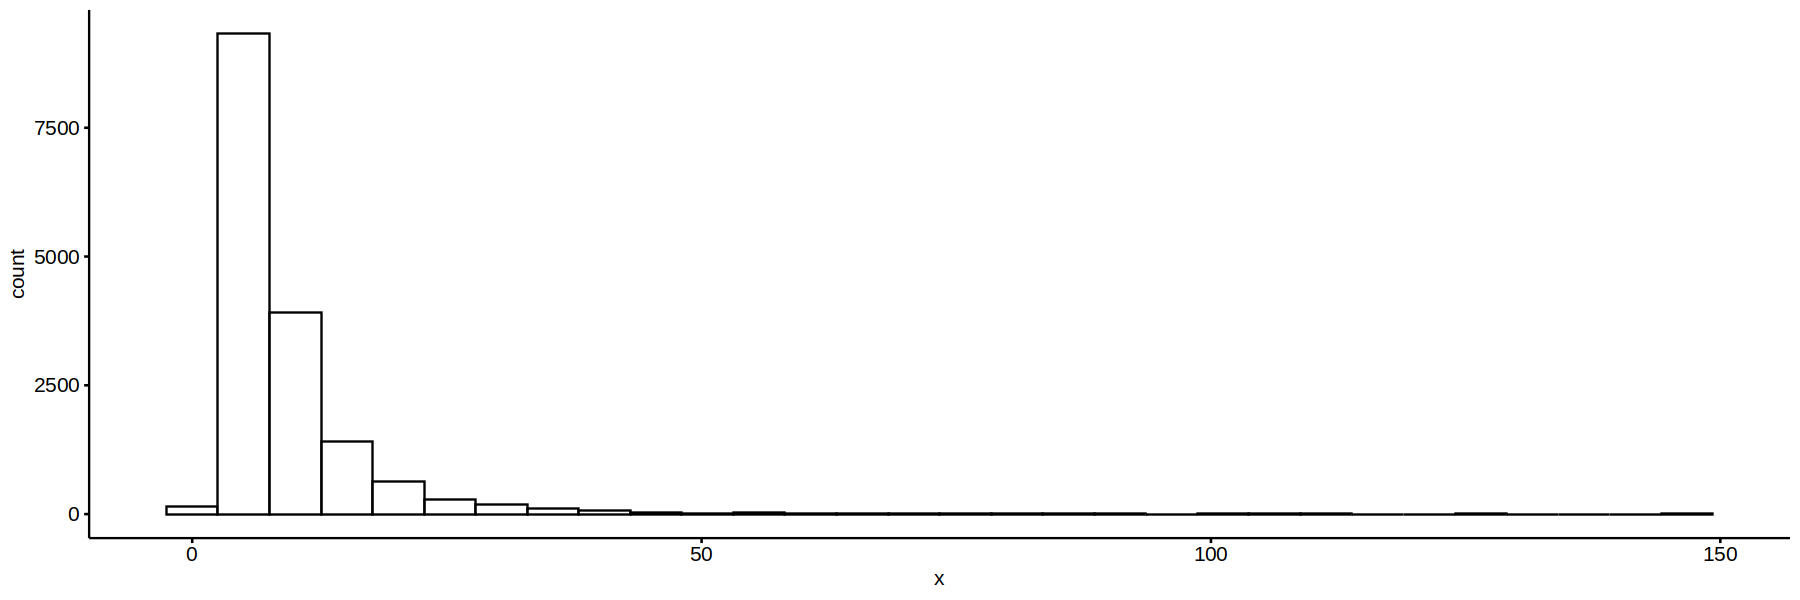

In [7]:
options(repr.plot.width=15, repr.plot.height=5)
gghistogram(zfp462[V5<150]$V5)

In [8]:
nrow(zfp462)

[1] 16264

In [45]:
zfp462.gr = makeGRangesFromDataFrame(zfp462[order(-V5)][V5>0][,c(1,2,3)] %>% 
                                         setnames(c('chr', 'start', 'end')) %>% 
                                        .[chr %in% paste0('chr', c(1:19, 'X'))] %>% head(3000))
zfp462.gr = GRangesList(zfp462.gr)
names(zfp462.gr) = 'Zfp462'

seFoot_zfp <- getFootprints(
  ArchRProj = ArchRProject, 
  positions = zfp462.gr, 
  groupBy = "celltype_genotype"
)

ArchR logging to : ArchRLogs/ArchR-getFootprints-3969c87064af96-Date-2023-05-29_Time-18-10-07.log
If there is an issue, please report to github with logFile!

2023-05-29 18:10:07 : Computing Kmer Bias Table, 0.003 mins elapsed.

2023-05-29 18:10:08 : Finished Computing Kmer Tables, 0.006 mins elapsed.

2023-05-29 18:10:08 : Computing Footprints, 0.01 mins elapsed.

2023-05-29 18:10:28 : Computing Footprints Bias, 0.342 mins elapsed.

2023-05-29 18:10:33 : Summarizing Footprints, 0.43 mins elapsed.



In [48]:
keep = unique(opts$clusters2celltypes)[unique(opts$clusters2celltypes) != 'Blood_Progenitor']
mclapply(keep, function(x){
    plotFootprints(
      seFoot = seFoot_zfp[, c(grep(paste0(x, '-KO'), colnames(seFoot_zfp)),
                         grep(paste0(x, '-WT'), colnames(seFoot_zfp)))],
      ArchRProj = ArchRProject, 
      normMethod = "subtract",
      plotName = paste0('Footprints_Zfp462_top3000_', x),
      addDOC = FALSE,
      smoothWindow = 10
)
}, mc.cores=12)

ArchR logging to : ArchRLogs/ArchR-plotFootprints-3969c8453fd562-Date-2023-05-29_Time-18-10-47.log
If there is an issue, please report to github with logFile!

2023-05-29 18:10:48 : Plotting Footprint : Zfp462 (1 of 1), 0.002 mins elapsed.

Applying smoothing window to footprint

Normalizing by flanking regions

NormMethod = subtract

ArchR logging successful to : ArchRLogs/ArchR-plotFootprints-3969c8453fd562-Date-2023-05-29_Time-18-10-47.log

ArchR logging to : ArchRLogs/ArchR-plotFootprints-3969c84f660942-Date-2023-05-29_Time-18-10-48.log
If there is an issue, please report to github with logFile!

2023-05-29 18:10:48 : Plotting Footprint : Zfp462 (1 of 1), 0.002 mins elapsed.

Applying smoothing window to footprint

Normalizing by flanking regions

NormMethod = subtract

ArchR logging successful to : ArchRLogs/ArchR-plotFootprints-3969c84f660942-Date-2023-05-29_Time-18-10-48.log

ArchR logging to : ArchRLogs/ArchR-plotFootprints-3969c83cf8ae3d-Date-2023-05-29_Time-18-10-49.log
If th

[[1]]
[1] 0

[[2]]
[1] 0

[[3]]
[1] 0

[[4]]
[1] 0

[[5]]
[1] 0

[[6]]
[1] 0

[[7]]
[1] 0

[[8]]
[1] 0

[[9]]
[1] 0

[[10]]
[1] 0

In [53]:
zfp462.gr = makeGRangesFromDataFrame(zfp462[order(-V5)][V5>0][,c(1,2,3)] %>% 
                                         setnames(c('chr', 'start', 'end')) %>% 
                                        .[chr %in% paste0('chr', c(1:19, 'X'))] %>% head(3000))
zfp462.gr = GRangesList(zfp462.gr)
names(zfp462.gr) = 'Zfp462'

seFoot_zfp <- getFootprints(
  ArchRProj = ArchRProject, 
  positions = zfp462.gr, 
  groupBy = "celltype_genotype",
  flank = 2000 
)

keep = unique(opts$clusters2celltypes)[unique(opts$clusters2celltypes) != 'Blood_Progenitor']
mclapply(keep, function(x){
    plotFootprints(
      seFoot = seFoot_zfp[, c(grep(paste0(x, '-KO'), colnames(seFoot_zfp)),
                         grep(paste0(x, '-WT'), colnames(seFoot_zfp)))],
      ArchRProj = ArchRProject, 
      normMethod = "subtract",
      plotName = paste0('Footprints_Zfp462_top3000_2kbFlank_', x),
      addDOC = FALSE,
      smoothWindow = 100
)
}, mc.cores=12)

ArchR logging to : ArchRLogs/ArchR-getFootprints-3969c84b125268-Date-2023-05-29_Time-18-17-23.log
If there is an issue, please report to github with logFile!

2023-05-29 18:17:23 : Computing Kmer Bias Table, 0.003 mins elapsed.

2023-05-29 18:17:24 : Finished Computing Kmer Tables, 0.017 mins elapsed.

2023-05-29 18:17:24 : Computing Footprints, 0.02 mins elapsed.

2023-05-29 18:17:41 : Computing Footprints Bias, 0.296 mins elapsed.

2023-05-29 18:17:46 : Summarizing Footprints, 0.381 mins elapsed.



[[1]]
[1] 0

[[2]]
[1] 0

[[3]]
[1] 0

[[4]]
[1] 0

[[5]]
[1] 0

[[6]]
[1] 0

[[7]]
[1] 0

[[8]]
[1] 0

[[9]]
[1] 0

[[10]]
[1] 0

In [221]:
zfp462.gr = makeGRangesFromDataFrame(zfp462[order(-V5)][V5>0][,c(1,2,3)] %>% 
                                         setnames(c('chr', 'start', 'end')) %>% 
                                        .[chr %in% paste0('chr', c(1:19, 'X'))])
zfp462.gr = GRangesList(zfp462.gr)
names(zfp462.gr) = 'Zfp462'

seFoot_zfp <- getFootprints(
  ArchRProj = ArchRProject, 
  positions = zfp462.gr, 
  groupBy = "celltype_genotype"
)

mclapply(keep, function(x){
    plotFootprints(
      seFoot = seFoot_zfp[, c(grep(paste0(x, '-KO'), colnames(seFoot_zfp)),
                         grep(paste0(x, '-WT'), colnames(seFoot_zfp)))],
      ArchRProj = ArchRProject, 
      normMethod = "subtract",
      plotName = paste0('Footprints_Zfp462_', x),
      addDOC = FALSE,
      smoothWindow = 10
)
}, mc.cores=24)

ArchR logging to : ArchRLogs/ArchR-getFootprints-20a03e67b083e5-Date-2023-05-28_Time-13-15-52.log
If there is an issue, please report to github with logFile!

2023-05-28 13:15:53 : Computing Kmer Bias Table, 0.004 mins elapsed.

2023-05-28 13:15:56 : Finished Computing Kmer Tables, 0.061 mins elapsed.

2023-05-28 13:15:56 : Computing Footprints, 0.065 mins elapsed.

2023-05-28 13:16:18 : Computing Footprints Bias, 0.422 mins elapsed.

2023-05-28 13:16:24 : Summarizing Footprints, 0.523 mins elapsed.



[[1]]
[1] 0

[[2]]
[1] 0

[[3]]
[1] 0

[[4]]
[1] 0

[[5]]
[1] 0

[[6]]
[1] 0

[[7]]
[1] 0

[[8]]
[1] 0

[[9]]
[1] 0

[[10]]
[1] 0

# footprint WT

In [25]:
# Load meta
meta = fread(args$metadata)[day!='D3'] %>% # remove D3 cells
    .[,celltype_genotype:=paste0(celltype_v1, '-', genotype)]

In [26]:
ArchRProject <- loadArchRProject(args$archr_directory)[meta$cell]

Successfully loaded ArchRProject!


                                                   / |
                                                 /    \
            .                                  /      |.
            \\\                              /        |.
              \\\                          /           `|.
                \\\                      /              |.
                  \                    /                |\
                  \\#####\           /                  ||
                ==###########>      /                   ||
                 \\##==......\    /                     ||
            ______ =       =|__ /__                     ||      \\\
        ,--' ,----`-,__ ___/'  --,-`-===================##========>
       \               '        ##_______ _____ ,--,__,=##,__   ///
        ,    __==    ___,-,__,--'#'  ==='      `-'    | ##,-/
        -,____,---'       \\####\\________________,--\\_##,/
           ___      .______        ______  __    __  .____

In [28]:
ArchRProject@projectMetadata$GroupCoverages$celltype_genotype = readRDS('/rds/project/rds-SDzz0CATGms/users/bt392/09_Eomes_invitro_blood/processed/atac/archR/GroupCoverages/celltype_genotype/GroupCoverages_metadata.rds')

In [29]:
ArchRProject <- addCellColData(ArchRProj = ArchRProject, 
                                    data = as.character(meta$celltype_genotype),
                                    cells = meta$cell,
                                    name = "celltype_genotype",
                                    force=TRUE)

Overriding previous entry for celltype_genotype



In [2]:
zfp462 = data.table::fread('/rds/project/rds-SDzz0CATGms/users/bt392/09_Eomes_invitro_blood/ChIP/zfp462/Ramesh/ZFP462_BioChIp_summits.bed')

In [31]:
zfp462.gr = makeGRangesFromDataFrame(zfp462[order(-V5)][V5>0][,c(1,2,3)] %>% 
                                         setnames(c('chr', 'start', 'end')) %>% 
                                        .[chr %in% paste0('chr', c(1:19, 'X'))] %>% head(3000))
zfp462.gr = GRangesList(zfp462.gr)
names(zfp462.gr) = 'Zfp462'

seFoot_zfp <- getFootprints(
  ArchRProj = ArchRProject, 
  positions = zfp462.gr, 
  groupBy = "celltype_genotype",
  flank = 2000 

)
keep = c('Primitive_Streak', 'Early_Mes_EOd', 'Early_Mes_EOi')
    plotFootprints(
      seFoot = seFoot_zfp[,c(grep('Primitive_Streak-WT', colnames(seFoot_zfp)),
                             grep('Early_Mes_EOd-WT', colnames(seFoot_zfp)),
                             grep('Early_Mes_EOi-WT', colnames(seFoot_zfp))
                             )],
      ArchRProj = ArchRProject, 
      normMethod = "subtract",
      plotName = paste0('Footprints_Zfp462_top3000_WTcelltypes'),
      addDOC = FALSE,
      smoothWindow = 100
)

ArchR logging to : ArchRLogs/ArchR-getFootprints-1d21005c6ce57e-Date-2023-05-31_Time-13-32-29.log
If there is an issue, please report to github with logFile!

2023-05-31 13:32:29 : Computing Kmer Bias Table, 0.004 mins elapsed.

2023-05-31 13:32:32 : Finished Computing Kmer Tables, 0.048 mins elapsed.

2023-05-31 13:32:32 : Computing Footprints, 0.052 mins elapsed.

2023-05-31 13:32:56 : Computing Footprints Bias, 0.451 mins elapsed.

2023-05-31 13:33:03 : Summarizing Footprints, 0.572 mins elapsed.

ArchR logging to : ArchRLogs/ArchR-plotFootprints-1d210026553db-Date-2023-05-31_Time-13-33-05.log
If there is an issue, please report to github with logFile!

2023-05-31 13:33:05 : Plotting Footprint : Zfp462 (1 of 1), 0.002 mins elapsed.

Applying smoothing window to footprint

Normalizing by flanking regions

NormMethod = subtract

ArchR logging successful to : ArchRLogs/ArchR-plotFootprints-1d210026553db-Date-2023-05-31_Time-13-33-05.log



In [32]:
zfp462.gr = makeGRangesFromDataFrame(zfp462[order(-V5)][V5>0][,c(1,2,3)] %>% 
                                         setnames(c('chr', 'start', 'end')) %>% 
                                        .[chr %in% paste0('chr', c(1:19, 'X'))])
zfp462.gr = GRangesList(zfp462.gr)
names(zfp462.gr) = 'Zfp462'

seFoot_zfp <- getFootprints(
  ArchRProj = ArchRProject, 
  positions = zfp462.gr, 
  groupBy = "celltype_genotype",
  flank = 2000 

)
keep = c('Primitive_Streak', 'Early_Mes_EOd', 'Early_Mes_EOi')
    plotFootprints(
      seFoot = seFoot_zfp[,c(grep('Primitive_Streak-WT', colnames(seFoot_zfp)),
                             grep('Early_Mes_EOd-WT', colnames(seFoot_zfp)),
                             grep('Early_Mes_EOi-WT', colnames(seFoot_zfp))
                             )],
      ArchRProj = ArchRProject, 
      normMethod = "subtract",
      plotName = paste0('Footprints_Zfp462_WTcelltypes'),
      addDOC = FALSE,
      smoothWindow = 100
)

ArchR logging to : ArchRLogs/ArchR-getFootprints-1d210040a7907d-Date-2023-05-31_Time-13-33-07.log
If there is an issue, please report to github with logFile!

2023-05-31 13:33:08 : Computing Kmer Bias Table, 0.003 mins elapsed.

2023-05-31 13:33:35 : Finished Computing Kmer Tables, 0.461 mins elapsed.

2023-05-31 13:33:35 : Computing Footprints, 0.464 mins elapsed.

2023-05-31 13:34:09 : Computing Footprints Bias, 1.025 mins elapsed.

2023-05-31 13:34:16 : Summarizing Footprints, 1.15 mins elapsed.

ArchR logging to : ArchRLogs/ArchR-plotFootprints-1d21002b8da967-Date-2023-05-31_Time-13-34-19.log
If there is an issue, please report to github with logFile!

2023-05-31 13:34:19 : Plotting Footprint : Zfp462 (1 of 1), 0.004 mins elapsed.

Applying smoothing window to footprint

Normalizing by flanking regions

NormMethod = subtract

ArchR logging successful to : ArchRLogs/ArchR-plotFootprints-1d21002b8da967-Date-2023-05-31_Time-13-34-19.log



In [37]:
zfp462.gr = makeGRangesFromDataFrame(zfp462[order(-V5)][V5>0][,c(1,2,3)] %>% 
                                         setnames(c('chr', 'start', 'end')) %>% 
                                        .[chr %in% paste0('chr', c(1:19, 'X'))])
zfp462.gr = GRangesList(zfp462.gr)
names(zfp462.gr) = 'Zfp462'

seFoot_zfp <- getFootprints(
  ArchRProj = ArchRProject, 
  positions = zfp462.gr, 
  groupBy = "celltype_genotype",
  flank = 2000 

)
    plotFootprints(
      seFoot = seFoot_zfp[,c(grep('Primitive_Streak-WT', colnames(seFoot_zfp)),
                             grep('Early_Mes_EOd-WT', colnames(seFoot_zfp)),
                             grep('HE_Precursor-WT', colnames(seFoot_zfp)),
                             grep('HE-WT', colnames(seFoot_zfp)),
                             grep('Blood_Progenitor-WT', colnames(seFoot_zfp))
                             )],
      ArchRProj = ArchRProject, 
      normMethod = "subtract",
      plotName = paste0('Footprints_Zfp462_WTcelltypes_Traj1'),
      addDOC = FALSE,
      smoothWindow = 100
)

ArchR logging to : ArchRLogs/ArchR-getFootprints-1d2100267c3a66-Date-2023-05-31_Time-13-56-03.log
If there is an issue, please report to github with logFile!

2023-05-31 13:56:03 : Computing Kmer Bias Table, 0.004 mins elapsed.

2023-05-31 13:56:08 : Finished Computing Kmer Tables, 0.076 mins elapsed.

2023-05-31 13:56:08 : Computing Footprints, 0.08 mins elapsed.

2023-05-31 13:56:44 : Computing Footprints Bias, 0.675 mins elapsed.

2023-05-31 13:56:49 : Summarizing Footprints, 0.765 mins elapsed.

ArchR logging to : ArchRLogs/ArchR-plotFootprints-1d210075517db4-Date-2023-05-31_Time-13-56-50.log
If there is an issue, please report to github with logFile!

2023-05-31 13:56:50 : Plotting Footprint : Zfp462 (1 of 1), 0.002 mins elapsed.

Applying smoothing window to footprint

Normalizing by flanking regions

NormMethod = subtract

ArchR logging successful to : ArchRLogs/ArchR-plotFootprints-1d210075517db4-Date-2023-05-31_Time-13-56-50.log



In [41]:
    plotFootprints(
      seFoot = seFoot_zfp[,c(grep('Primitive_Streak-KO', colnames(seFoot_zfp)),
                             grep('Early_Mes_EOd-KO', colnames(seFoot_zfp)),
                             grep('HE_Precursor-KO', colnames(seFoot_zfp)),
                             grep('HE-KO', colnames(seFoot_zfp)))],
      ArchRProj = ArchRProject, 
      normMethod = "subtract",
      plotName = paste0('Footprints_Zfp462_KDcelltypes_Traj1'),
      addDOC = FALSE,
      smoothWindow = 100
)

ArchR logging to : ArchRLogs/ArchR-plotFootprints-1d21003611855a-Date-2023-05-31_Time-13-58-46.log
If there is an issue, please report to github with logFile!

2023-05-31 13:58:46 : Plotting Footprint : Zfp462 (1 of 1), 0.003 mins elapsed.

Applying smoothing window to footprint

Normalizing by flanking regions

NormMethod = subtract

ArchR logging successful to : ArchRLogs/ArchR-plotFootprints-1d21003611855a-Date-2023-05-31_Time-13-58-46.log



In [35]:
unique(ArchRProject@cellColData$celltype_genotype)

[1] "Early_Mes_EOd-WT"       "Early_Mes_EOi-WT"       "Primitive_Streak-WT"   
 [4] "Posterior_Mes-WT"       "HE_Precursor-WT"        "HE-WT"                 
 [7] "Mesenchyme-WT"          "Early_Mes_EOi-KO"       "Primitive_Streak-KO"   
[10] "Early_Mes_EOd-KO"       "Mesenchyme-KO"          "Posterior_Mes-KO"      
[13] "HE_Precursor-KO"        "HE-KO"                  "Allantois_Precursor-WT"
[16] "Blood_Progenitor-WT"    "Endothelium-WT"         "Allantois_Precursor-KO"
[19] "Endothelium-KO"         "Allantois-WT"           "Allantois-KO"          
[22] "Blood_Progenitor-KO"

In [42]:
    plotFootprints(
      seFoot = seFoot_zfp[,c(grep('Primitive_Streak-WT', colnames(seFoot_zfp)),
                             grep('Early_Mes_EOi-WT', colnames(seFoot_zfp)),
                             grep('Mesenchyme-WT', colnames(seFoot_zfp)),
                             grep('Posterior_Mes-WT', colnames(seFoot_zfp)),
                             grep('Allantois_Precursor-WT', colnames(seFoot_zfp)),
                             grep('Allantois-WT', colnames(seFoot_zfp))
                             )],
      ArchRProj = ArchRProject, 
      normMethod = "subtract",
      plotName = paste0('Footprints_Zfp462_WTcelltypes_Traj2'),
      addDOC = FALSE,
      smoothWindow = 100
)

ArchR logging to : ArchRLogs/ArchR-plotFootprints-1d210052642134-Date-2023-05-31_Time-13-59-57.log
If there is an issue, please report to github with logFile!

2023-05-31 13:59:57 : Plotting Footprint : Zfp462 (1 of 1), 0.002 mins elapsed.

Applying smoothing window to footprint

Normalizing by flanking regions

NormMethod = subtract

ArchR logging successful to : ArchRLogs/ArchR-plotFootprints-1d210052642134-Date-2023-05-31_Time-13-59-57.log



In [43]:
    plotFootprints(
      seFoot = seFoot_zfp[,c(grep('Primitive_Streak-KO', colnames(seFoot_zfp)),
                             grep('Early_Mes_EOi-KO', colnames(seFoot_zfp)),
                             grep('Mesenchyme-KO', colnames(seFoot_zfp)),
                             grep('Posterior_Mes-KO', colnames(seFoot_zfp)),
                             grep('Allantois_Precursor-KO', colnames(seFoot_zfp)),
                             grep('Allantois-KO', colnames(seFoot_zfp))
                             )],
      ArchRProj = ArchRProject, 
      normMethod = "subtract",
      plotName = paste0('Footprints_Zfp462_KOcelltypes_Traj2'),
      addDOC = FALSE,
      smoothWindow = 100
)

ArchR logging to : ArchRLogs/ArchR-plotFootprints-1d2100570ad6fe-Date-2023-05-31_Time-14-02-09.log
If there is an issue, please report to github with logFile!

2023-05-31 14:02:09 : Plotting Footprint : Zfp462 (1 of 1), 0.003 mins elapsed.

Applying smoothing window to footprint

Normalizing by flanking regions

NormMethod = subtract

ArchR logging successful to : ArchRLogs/ArchR-plotFootprints-1d2100570ad6fe-Date-2023-05-31_Time-14-02-09.log



In [35]:
unique(ArchRProject@cellColData$celltype_genotype)

[1] "Early_Mes_EOd-WT"       "Early_Mes_EOi-WT"       "Primitive_Streak-WT"   
 [4] "Posterior_Mes-WT"       "HE_Precursor-WT"        "HE-WT"                 
 [7] "Mesenchyme-WT"          "Early_Mes_EOi-KO"       "Primitive_Streak-KO"   
[10] "Early_Mes_EOd-KO"       "Mesenchyme-KO"          "Posterior_Mes-KO"      
[13] "HE_Precursor-KO"        "HE-KO"                  "Allantois_Precursor-WT"
[16] "Blood_Progenitor-WT"    "Endothelium-WT"         "Allantois_Precursor-KO"
[19] "Endothelium-KO"         "Allantois-WT"           "Allantois-KO"          
[22] "Blood_Progenitor-KO"

In [33]:

    plotFootprints(
      seFoot = seFoot_zfp[,c(grep('Primitive_Streak-KO', colnames(seFoot_zfp)),
                             grep('Early_Mes_EOd-KO', colnames(seFoot_zfp)),
                             grep('Early_Mes_EOi-KO', colnames(seFoot_zfp))
                             )],
      ArchRProj = ArchRProject, 
      normMethod = "subtract",
      plotName = paste0('Footprints_Zfp462_KDcelltypes'),
      addDOC = FALSE,
      smoothWindow = 100
)

ArchR logging to : ArchRLogs/ArchR-plotFootprints-1d21003d44a80b-Date-2023-05-31_Time-13-36-33.log
If there is an issue, please report to github with logFile!

2023-05-31 13:36:33 : Plotting Footprint : Zfp462 (1 of 1), 0.003 mins elapsed.

Applying smoothing window to footprint

Normalizing by flanking regions

NormMethod = subtract

ArchR logging successful to : ArchRLogs/ArchR-plotFootprints-1d21003d44a80b-Date-2023-05-31_Time-13-36-33.log

